## Import libraries!

In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn import svm




## Load data

In [74]:
df = pd.read_csv('../data/train.csv')
df['EVDtH'] = df.Elevation-df.Vertical_Distance_To_Hydrology
df['EHDtH'] = df.Elevation-df.Horizontal_Distance_To_Hydrology*0.2
df['Highwater'] = df.Vertical_Distance_To_Hydrology < 0

def zF(x, y):
    if x == 0:
        return y
    else:
        return x
def r(x):
    if x+180>360:
        return x-180
    else:
        return x+180

df['Aspect2'] = df.Aspect.map(r)
df.ix[df.Hillshade_3pm==0, 'Hillshade_3pm'] = df.Hillshade_3pm.median()
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
train, validation = df[df['is_train']==True], df[df['is_train']==False]
one_two = df[(df['Cover_Type']<3)] 
test = pd.read_csv('../data/covtype.data')
test['Id'] = range(1, len(test)+1)
test['is_train'] = False
test['Aspect2'] = test.Aspect.map(r)
test.ix[test.Hillshade_3pm==0, 'Hillshade_3pm'] = test.Hillshade_3pm.median()
test['is_train'] = False
test['EVDtH'] = test.Elevation-test.Vertical_Distance_To_Hydrology
test['EHDtH'] = test.Elevation-test.Horizontal_Distance_To_Hydrology*0.2
test['Highwater'] = test.Vertical_Distance_To_Hydrology < 0

## Graphing continuous input variables

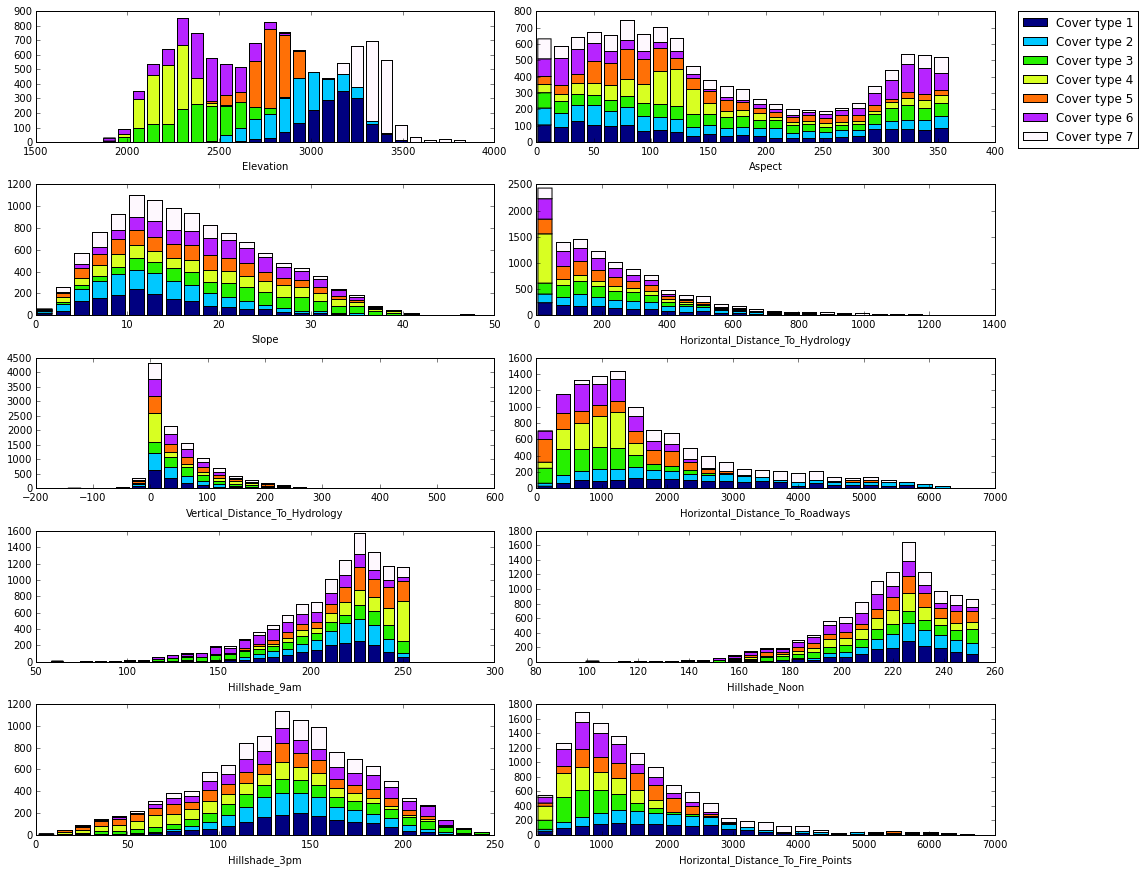

In [4]:
#list(train.columns.values[1:11])
fig = plt.figure(figsize=(14,12))

color_list = plt.cm.get_cmap("gist_ncar", 7)

for i in range(1, 11):
    y_split_sets = []
    for j in range(1,8):
        y_split_sets.append(train[train['Cover_Type']==j].ix[:,i])

    ax = fig.add_subplot(5,2,i)
    plt.hist(y_split_sets, 25, stacked=True, label=["Cover type "+str(i) for i in range(1,8)], color=color_list(np.arange(7)))
    plt.xlabel(train.columns.values[i])
    if(i==2):
        patches, labels = ax.get_legend_handles_labels()
        plt.legend(patches, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

## Soil Types Graph

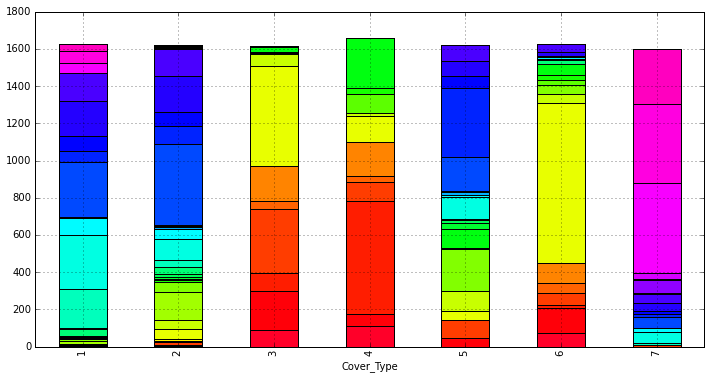

In [4]:
soil_cols = [a for a in list(train.columns.values) if a[:4] == "Soil"]

table = train.groupby("Cover_Type").sum()[soil_cols]

table.plot(kind='bar', stacked=True, legend=False, colormap="gist_rainbow", figsize=(12, 6))
plt.show()

## Wilderness Areas Graph

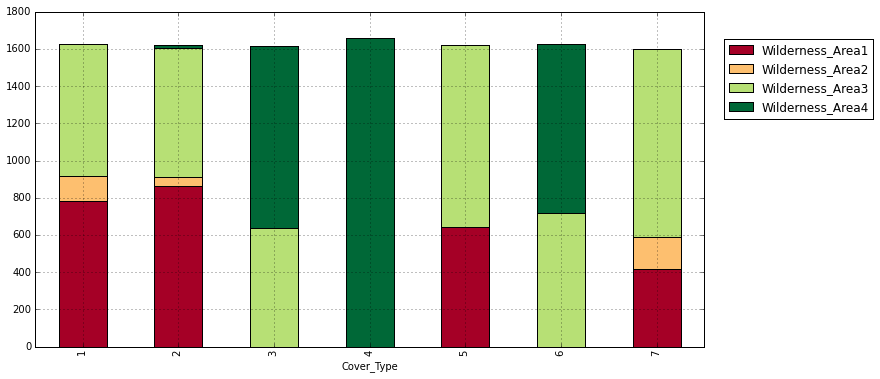

In [5]:
wa_cols = [a for a in list(train.columns.values) if a[:15] == "Wilderness_Area"]

table = train.groupby("Cover_Type").sum()[wa_cols]
ax = table.plot(kind='bar', legend=False, stacked=True, colormap="RdYlGn", figsize=(12, 6))

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='center left', bbox_to_anchor=(1.02, 0.8))

## Feature engineering

In [75]:
features = [col for col in train.columns if col not in ['Cover_Type','Id','is_train']]

X_train = train[features]
X_validation = validation[features]
y_training = train['Cover_Type']
y_validation = validation['Cover_Type']
y_one = one_two['Cover_Type']
x_one = one_two[features]
x_test = test[features]
y_test = test['Cover_Type']

## Random Forest Test

In [78]:
clf = RandomForestClassifier()
clf.fit(X_train, y_training)
pd.Series([
        accuracy_score(y_training, clf.predict(X_train)),
        accuracy_score(y_validation, clf.predict(X_validation))
    ], index=["Training accuracy", "Test accuracy"])




Training accuracy    0.993765
Test accuracy        0.843557
dtype: float64

[[399  85   1   0   8   0  31]
 [115 318  13   0  32  12   8]
 [  0   5 440  28   2  67   0]
 [  0   0  16 512   0   9   0]
 [  3  33   8   0 528   3   0]
 [  0   5  62  10   2 410   0]
 [ 24   2   0   0   0   0 542]]


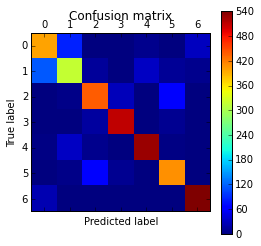

In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_validation, clf.predict(X_validation))
print(cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Naive Bayes Test

In [16]:
gnb = GaussianNB()
gnb_fitted = gnb.fit(train[features], y_training)
pd.Series([
        accuracy_score(y_training, gnb_fitted.predict(train[features])),
        accuracy_score(y_validation, gnb_fitted.predict(validation[features]))
   ], index=["Training accuracy", "Test accuracy"])




Training accuracy    0.476421
Test accuracy        0.491209
dtype: float64

In [80]:
rt = .36
md = 5
ne = 400
mf = None
gbm = GradientBoostingClassifier(learning_rate=rt, max_depth=md, n_estimators=ne, max_features=mf)
gbm.fit(X_train, y_training)
pd.Series([
        accuracy_score(y_training, gbm.predict(X_train)),
        accuracy_score(y_validation, gbm.predict(X_validation))
    ], index=["Training accuracy", "Test accuracy"])




Training accuracy    1.000000
Test accuracy        0.863649
dtype: float64

In [54]:
pd.DataFrame(clf.feature_importances_,index=X_train.columns).sort([0], ascending=False) 

,0
EHDtH,0.149791
EVDtH,0.119237
Elevation,0.102733
Horizontal_Distance_To_Roadways,0.071822
Horizontal_Distance_To_Fire_Points,0.056363
Horizontal_Distance_To_Hydrology,0.047169
Vertical_Distance_To_Hydrology,0.042998
Hillshade_Noon,0.038909
Hillshade_9am,0.038526
Wilderness_Area4,0.037429


In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train.astype(np.float))
scaled_validation = scaler.transform(X_validation.astype(np.float))

scaled_train = pd.DataFrame(scaled_train, columns=features)
scaled_validation = pd.DataFrame(scaled_validation, columns=features)

feature_importances = []
for i in range(0, len(clf.feature_importances_)):
    feature_importances.append((clf.feature_importances_[i] + 0.005)*5)

col_index = 0
for col in features:
    scaled_train[col] = scaled_train[col]*feature_importances[col_index]
    scaled_validation[col] = scaled_validation[col]*feature_importances[col_index]
    col_index += 1

neighbor = KNeighborsClassifier(n_neighbors=5) #weights="distance"
neighbor_fitted = neighbor.fit(scaled_train, y_training)
pd.Series([
        accuracy_score(y_training, neighbor_fitted.predict(scaled_train)),
        accuracy_score(y_validation, neighbor_fitted.predict(scaled_validation))
    ], index=["Training accuracy", "Test accuracy"])


Training accuracy    0.886976
Test accuracy        0.829628
dtype: float64

In [82]:
scaler = StandardScaler()
scaled_train2 = scaler.fit_transform(X_train.astype(np.float))
scaled_validation2 = scaler.transform(X_validation.astype(np.float))

scaled_train2 = pd.DataFrame(scaled_train2, columns=features)
scaled_validation2 = pd.DataFrame(scaled_validation2, columns=features)

rbf_svc = svm.SVC(C=1500, kernel="rbf", max_iter=-1) #5.5, 200
svm_fitted = rbf_svc.fit(scaled_train2, y_training)
pd.Series([
   accuracy_score(y_training, svm_fitted.predict(scaled_train2)),
   accuracy_score(y_validation, svm_fitted.predict(scaled_validation2))
 ], index=["Training accuracy", "Test accuracy"])
      

Training accuracy    0.949328
Test accuracy        0.817841
dtype: float64

In [83]:
svm_predict = svm_fitted.predict(scaled_validation2)
gbm_predict = gbm.predict(X_validation)
nn_predict = neighbor_fitted.predict(scaled_validation)
ot_predict = clf.fit(x_one, y_one).predict(X_validation)
voted_predict = []
for i in range(0,len(svm_predict)):
    a = np.array([svm_predict[i], nn_predict[i], gbm_predict[i]])
    (values,counts) = np.unique(a,return_counts=True)
    ind=np.argmax(counts)
    ret = values[ind]
    if ret==1 or ret==2:
        ret = ot_predict[i]
    voted_predict.append(ret)

accuracy_score(y_validation, voted_predict)

0.91079560675060278

[[400  88   0   0  13   3  37]
 [107 332  13   0  66  13   4]
 [  0   5 413  37  12  72   0]
 [  0   0   9 528   0   6   0]
 [  1   9   2   0 510   5   0]
 [  0   2  54  19   8 433   0]
 [ 19   1   0   0   0   0 533]]


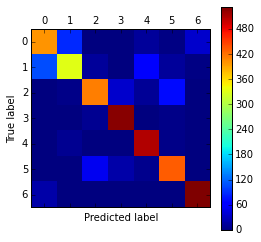

In [43]:
cm = confusion_matrix(y_validation, nn_predict)
print(cm)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()